
# Perpetuals Simulation Notebook

This notebook provides a **clean, modular** simulation framework for perpetual futures (perps) to accompany a theoretical paper.  
It focuses on: (i) a flexible price-path generator, (ii) perp mechanics (fees, funding, liquidation), (iii) single-path and batch simulations, (iv) sensitivity studies and visualizations.

> **Design goals:** transparency, reproducibility, and ease of extension for protocol-specific rules.



## Contents
1. [Setup](#setup)  
2. [Price Processes](#price)  
3. [Perp Mechanics](#mechanics)  
4. [Single-Path Simulation](#single)  
5. [Batch Simulation & Metrics](#batch)  
6. [Sensitivity Studies (Leverage, Volatility, Fees)](#sensitivity)  
   - 6.1 Liquidation Probability (%) heatmap  
   - 6.2 Median Realized PnL heatmap  
7. [Protocol-Style Presets (Example)](#presets)  
8. [Reproducibility Tests](#tests)  
9. [Appendix A — Fully Commented, Drop-in Implementations](#appendixA)



<a id='setup'></a>

## 1) Setup


In [2]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple, List

# Reproducibility
np.random.seed(42)

# Display options
pd.set_option("display.precision", 6)
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 120)



<a id='price'></a>

## 2) Price Processes

We model the underlying price asset with a discrete-time exact solution of the continuous-time GBM SDE $dS_t = \mu S_t\,dt + \sigma S_t\,dW_t$.
On a uniform grid with step $\Delta t$, the update is

$$
S_{t+\Delta t}
= S_t \,\exp\!\Big( (\mu - \tfrac{1}{2}\sigma^2)\,\Delta t \;+\; \sigma\sqrt{\Delta t}\,\varepsilon_t \Big),
\qquad \varepsilon_t \sim \mathcal{N}(0,1)\ \text{i.i.d.}
$$

**Elements and units (as used in this notebook):**

* $S_t$: spot price at time $t$ (in quote currency).
* $S_{t+\Delta t}$: next-step spot price.
* $\Delta t$: time step; we measure **in days** (e.g., $\Delta t = 1/24$ for hourly steps).
* $\mu$: drift per day under the chosen measure (real-world or risk-neutral).
  • Risk-neutral note: with continuous rate $r$ and dividend/yield $q$, replace $\mu$ by $r - q$ (or set $\mu = 0$ if prices are already discounted).
* $\sigma$: volatility per $\sqrt{\text{day}}$.
* $\varepsilon_t$: i.i.d. standard Normal shocks, $\varepsilon_t \overset{\text{i.i.d.}}{\sim} \mathcal{N}(0,1)$, independent across time. The factor $\sqrt{\Delta t}$ ensures that variance scales linearly with elapsed time.

**Deterministic vs. random parts:**

* **Drift term** $(\mu - \tfrac{1}{2}\sigma^2)\Delta t$: includes the **Itô/Jensen correction** $-\tfrac{1}{2}\sigma^2$ 
* **Diffusion term** $\sigma\sqrt{\Delta t}\,\varepsilon_t$: the random innovation.





In [16]:
dataclass
class PriceProcessParams:
    S0: float = 100.0      # initial spot price
    mu: float = 0.0        # drift per day
    sigma: float = 0.5     # volatility per sqrt(day)
    T: float = 7.0         # time horizon in days
    dt: float = 1/24       # step size in days (hourly)

def generate_price_path(p: PriceProcessParams, rng: np.random.Generator | None = None) -> pd.DataFrame:
    """
    Geometric Brownian Motion (GBM), exact step:
      S_{t+Δt} = S_t * exp( (μ - 0.5 σ^2) Δt + σ √Δt ε_t ),  ε_t ~ N(0,1)

    Returns a DataFrame with columns:
      - t (days)  : [0, dt, ..., T]
      - S (price) : simulated spot
    """
    if rng is None:
        rng = np.random.default_rng()

    n_steps = int(np.round(p.T / p.dt))
    times = np.linspace(0.0, p.T, n_steps + 1)

    S = np.empty(n_steps + 1, dtype=float)
    S[0] = p.S0

    drift = (p.mu - 0.5 * p.sigma**2) * p.dt
    scale = p.sigma * np.sqrt(p.dt)

    for t in range(n_steps):
        z = rng.standard_normal()
        S[t + 1] = S[t] * np.exp(drift + scale * z)

    return pd.DataFrame({"t": times, "S": S})


<a id='mechanics'></a>

## 3) Perp Mechanics

We assume a **cross-margined** perp position with:
- **Collateral** $C$ and **leverage** $L$ → notional $N = L\cdot C$.
- **Trading fees** on open and close at rate $f_{\text{trade}}$ times notional.
- **Borrow fee** accruing at rate $f_{\text{borrow}}$ on notional per unit time (scaled by $\Delta t$).
- **Funding payments** based on a funding rate process $r^{\text{fund}}_t$. By default, we model a simple premium-to-EMA proxy.
- **Maintenance margin rate** $m_{\mathrm{maint}}$; liquidation occurs when the **margin ratio** $\mathrm{MR}_t = \frac{\text{Equity}_t}{N_t}$ falls below $m_{\mathrm{maint}}$.

**Equity** at time $t$:
$
\text{Equity}_t = C + \text{UPnL}_t - (\text{Fees}^{\text{open}} + \text{Fees}^{\text{borrow}}_{\le t} + \text{Fees}^{\text{fund}}_{\le t}),
$
with unrealized PnL $\text{UPnL}_t$ computed from the mark $S_t$ relative to entry $S_0$.


In [4]:

@dataclass
class PerpParams:
    is_long: bool = True
    collateral: float = 1000.0
    leverage: float = 10.0
    trading_fee_rate: float = 0.0006   # per open/close on notional
    borrow_fee_rate: float = 0.000027  # per unit time (same time unit as dt)
    maintenance_margin_rate: float = 0.005
    slippage_bps_open: float = 0.0     # applied once at entry as additional fee on notional
    slippage_bps_close: float = 0.0    # optional
    apply_funding_fee: bool = False
    funding_kappa: float = 0.0         # strength of funding vs premium proxy
    funding_ema_span: int = 24         # EMA span (steps) for premium proxy

def ema(series: np.ndarray, span: int) -> np.ndarray:
    if span <= 1:
        return series.copy()
    alpha = 2.0/(span+1)
    y = np.empty_like(series, dtype=float)
    y[0] = series[0]
    for i in range(1, len(series)):
        y[i] = alpha*series[i] + (1-alpha)*y[i-1]
    return y

def simulate_perp_single(price_df: pd.DataFrame, perp: PerpParams) -> Dict[str, Any]:
    S = price_df["S"].values
    t = price_df["t"].values
    dt = np.diff(t, prepend=t[0])
    dt[0] = dt[1] if len(dt) > 1 else dt[0]

    S0 = S[0]
    notional = perp.leverage * perp.collateral
    q = (notional / S0) * (1.0 if perp.is_long else -1.0)

    # Fees at open
    open_trading_fee = perp.trading_fee_rate * abs(notional)
    open_slippage_fee = (perp.slippage_bps_open/1e4) * abs(notional)
    fees_open = open_trading_fee + open_slippage_fee

    # Funding setup (simple premium proxy vs EMA)
    if perp.apply_funding_fee and perp.funding_kappa != 0.0:
        ema_S = ema(S, span=perp.funding_ema_span)
        premium = (S - ema_S) / np.maximum(ema_S, 1e-12)  # dimensionless
        funding_rate_path = perp.funding_kappa * premium
    else:
        funding_rate_path = np.zeros_like(S)

    equity = np.empty_like(S, dtype=float)
    upnl = np.empty_like(S, dtype=float)
    cum_funding_fee = 0.0
    cum_borrow_fee = 0.0

    liquidated = False
    liq_index = -1

    for i in range(len(S)):
        price_now = S[i]
        upnl[i] = q * (price_now - S0)

        if i > 0:
            # Borrow fee on notional
            cum_borrow_fee += perp.borrow_fee_rate * abs(notional) * dt[i]
            # Funding fee: pay/receive q * S * funding_rate * dt (sign via q)
            cum_funding_fee += (np.sign(q) * abs(notional) * funding_rate_path[i] * dt[i])

        total_fees = fees_open + cum_borrow_fee + cum_funding_fee
        equity[i] = perp.collateral + upnl[i] - total_fees

        # Liquidation check (margin ratio vs maintenance)
        notional_now = abs(q) * price_now
        mr = equity[i] / max(notional_now, 1e-12)

        if (not liquidated) and (mr <= perp.maintenance_margin_rate):
            liquidated = True
            liq_index = i
            # On liquidation we close the position at current price and add closing trading fee + slippage (optional)
            close_fee = perp.trading_fee_rate * notional_now + (perp.slippage_bps_close/1e4) * notional_now
            equity[i] -= close_fee
            # Set the rest of the path post-liquidation equal to equity at liq
            equity[i:] = equity[i]
            upnl[i:] = upnl[i]
            break

    # If not liquidated, apply closing fees at the end
    if not liquidated:
        notional_end = abs(q) * S[-1]
        close_fee = perp.trading_fee_rate * notional_end + (perp.slippage_bps_close/1e4) * notional_end
        equity[-1] -= close_fee

    out = {
        "equity_path": equity,
        "upnl_path": upnl,
        "funding_rate_path": funding_rate_path,
        "price_path": S,
        "time": t,
        "liquidated": liquidated,
        "liq_index": liq_index,
        "final_equity": float(equity[-1]),
        "final_upnl": float(upnl[-1]),
        "fees_open": float(fees_open),
        "cum_borrow_fee": float(cum_borrow_fee),
        "cum_funding_fee": float(cum_funding_fee),
    }
    return out



<a id='single'></a>

## 4) Single-Path Simulation

Use `PriceProcessParams` and `PerpParams` to define the market and position.  
The helper below runs one scenario and draws (i) price & equity paths and (ii) fee breakdown at the end.


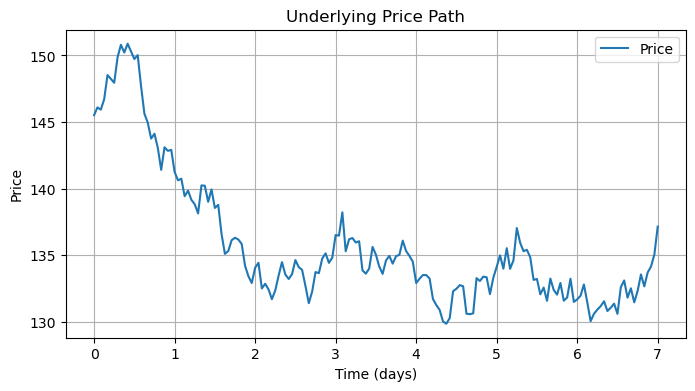

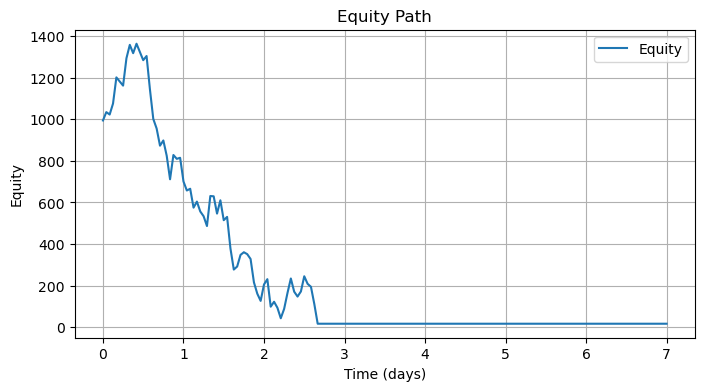

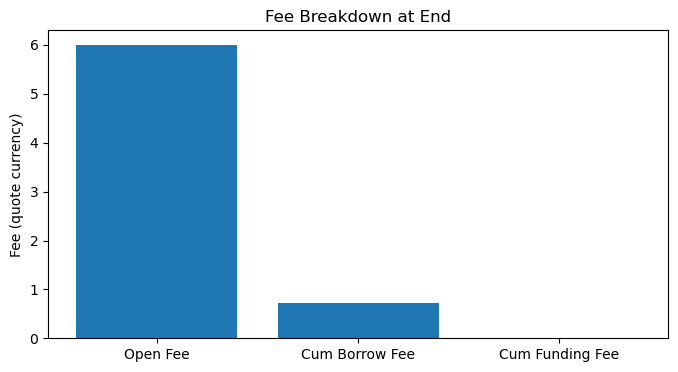

In [5]:

def run_single_demo(
    price_params: PriceProcessParams = PriceProcessParams(S0=145.51, mu=0.0, sigma=0.04, T=7, dt=1/24),
    perp_params: PerpParams = PerpParams(is_long=True, collateral=1000.0, leverage=10.0, 
                                         trading_fee_rate=0.0006, borrow_fee_rate=0.000027,
                                         maintenance_margin_rate=0.002556, apply_funding_fee=False)
) -> Dict[str, Any]:
    price_df = generate_price_path(price_params)
    res = simulate_perp_single(price_df, perp_params)

    # Plot price
    fig1 = plt.figure(figsize=(8, 4))
    ax = plt.gca()
    ax.plot(res["time"], res["price_path"], label="Price")
    ax.set_xlabel("Time (days)")
    ax.set_ylabel("Price")
    ax.set_title("Underlying Price Path")
    ax.grid(True)
    ax.legend()
    plt.show()

    # Plot equity
    fig2 = plt.figure(figsize=(8, 4))
    ax2 = plt.gca()
    ax2.plot(res["time"], res["equity_path"], label="Equity")
    ax2.set_xlabel("Time (days)")
    ax2.set_ylabel("Equity")
    ax2.set_title("Equity Path")
    ax2.grid(True)
    ax2.legend()
    plt.show()

    # Fee breakdown at end
    fig3 = plt.figure(figsize=(8, 4))
    ax3 = plt.gca()
    fees_dict = {
        "Open Fee": res["fees_open"],
        "Cum Borrow Fee": res["cum_borrow_fee"],
        "Cum Funding Fee": res["cum_funding_fee"],
    }
    ax3.bar(list(fees_dict.keys()), list(fees_dict.values()))
    ax3.set_title("Fee Breakdown at End")
    ax3.set_ylabel("Fee (quote currency)")
    plt.show()

    return {"price_df": price_df, "result": res}

# Quick demo run (can be commented if not needed)
_ = run_single_demo()



<a id='batch'></a>

## 5) Batch Simulation & Metrics

We now simulate many paths to obtain distributions for **final equity**, **realized PnL**, and **liquidation probability**.


Runs: 2000
Average PnL: -21.66
Liquidation probability: 34.55%


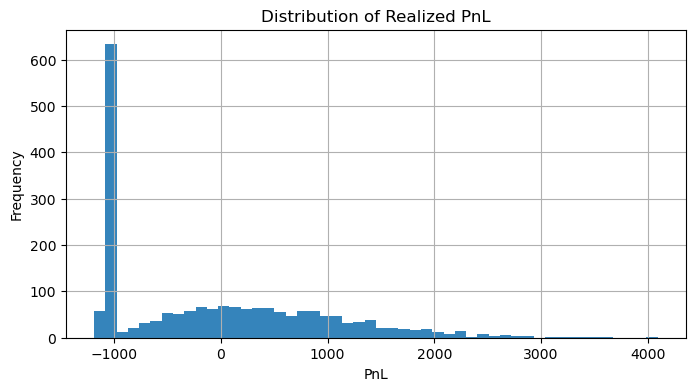

In [7]:

def simulate_batch(n_runs: int, price_params: PriceProcessParams, perp_params: PerpParams, 
                   capture_paths: bool=False) -> Dict[str, Any]:
    finals = []
    liqs = []
    records: List[Dict[str, Any]] = []
    paths_equity = []
    for _ in range(n_runs):
        price_df = generate_price_path(price_params)
        res = simulate_perp_single(price_df, perp_params)
        finals.append(res["final_equity"] - perp_params.collateral)  # realized PnL after close/liq
        liqs.append(res["liquidated"])
        records.append({
            "final_equity": res["final_equity"],
            "realized_pnl": res["final_equity"] - perp_params.collateral,
            "liquidated": res["liquidated"]
        })
        if capture_paths:
            paths_equity.append(res["equity_path"])

    df = pd.DataFrame(records)
    return {
        "df": df,
        "avg_pnl": float(np.mean(finals)),
        "liq_prob": float(np.mean(liqs)),
        "paths_equity": paths_equity
    }

def plot_pnl_distribution(df: pd.DataFrame):
    plt.figure(figsize=(8, 4))
    plt.hist(df["realized_pnl"], bins=50, alpha=0.9)
    plt.title("Distribution of Realized PnL")
    plt.xlabel("PnL")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

# Example batch run
batch_out = simulate_batch(
    n_runs=2000,
    price_params=PriceProcessParams(S0=145.51, mu=0.0, sigma=0.04, T=7, dt=1/24),
    perp_params=PerpParams(is_long=True, collateral=1000.0, leverage=10.0, 
                           trading_fee_rate=0.0006, borrow_fee_rate=0.000027, 
                           maintenance_margin_rate=0.002556, apply_funding_fee=False)
)
print(f"Runs: {len(batch_out['df'])}")
print(f"Average PnL: {batch_out['avg_pnl']:.2f}")
print(f"Liquidation probability: {batch_out['liq_prob']*100:.2f}%")
plot_pnl_distribution(batch_out["df"])

# Save results as CSV for paper appendix if useful
#batch_out["df"].to_csv("/mnt/data/perps_batch_results.csv", index=False)



<a id='sensitivity'></a>

## 6) Sensitivity Studies (Leverage, Volatility, Fees)

We explore how risk and performance evolve as we vary parameters.  
First, we provide **Liquidation Probability (%)** across (σ, leverage). Second, we add a **Median Realized PnL** heatmap to avoid VaR/ES concepts while still centering on PnL.


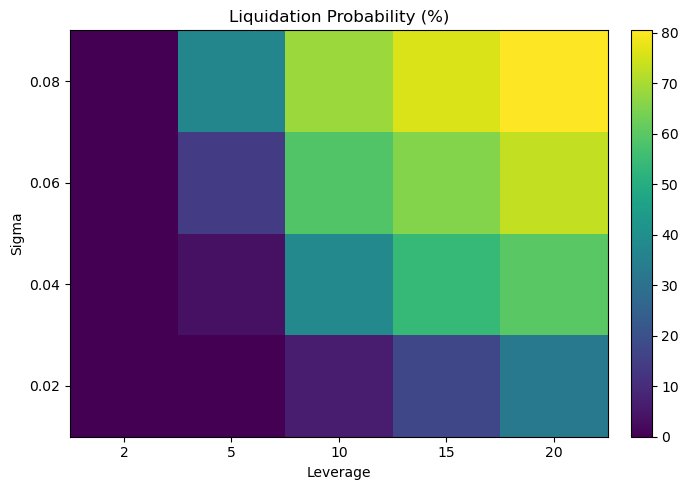

In [8]:

def leverage_sweep(leverage_list: List[float], n_runs: int,
                   price_params: PriceProcessParams, base_perp: PerpParams) -> pd.DataFrame:
    rows = []
    for L in leverage_list:
        perp = PerpParams(**{**base_perp.__dict__, "leverage": L})
        out = simulate_batch(n_runs=n_runs, price_params=price_params, perp_params=perp)
        rows.append({
            "leverage": L,
            "avg_pnl": out["avg_pnl"],
            "liq_prob": out["liq_prob"]
        })
    return pd.DataFrame(rows)

def plot_leverage_sweep(df: pd.DataFrame):
    fig = plt.figure(figsize=(8,4))
    ax = plt.gca()
    ax.plot(df["leverage"], df["avg_pnl"], marker="o", label="Average PnL")
    ax.set_xlabel("Leverage")
    ax.set_ylabel("Average PnL")
    ax.grid(True)
    ax.legend()
    plt.show()

    fig2 = plt.figure(figsize=(8,4))
    ax2 = plt.gca()
    ax2.plot(df["leverage"], 100*df["liq_prob"], marker="o", label="Liquidation Probability (%)")
    ax2.set_xlabel("Leverage")
    ax2.set_ylabel("Liquidation Probability (%)")
    ax2.grid(True)
    ax2.legend()
    plt.show()

# Base grids
price_p = PriceProcessParams(S0=145.51, mu=0.0, sigma=0.04, T=7, dt=1/24)
perp_base = PerpParams(is_long=True, collateral=1000.0, leverage=10.0, 
                       trading_fee_rate=0.0006, borrow_fee_rate=0.000027, 
                       maintenance_margin_rate=0.002556, apply_funding_fee=False)

# 6.1) Liquidation Probability (%) heatmap
def heatmap_liq_prob(leverage_list: List[float], sigma_list: List[float], n_runs: int,
                     base_price: PriceProcessParams, base_perp: PerpParams) -> Tuple[np.ndarray, List[float], List[float]]:
    H = np.zeros((len(sigma_list), len(leverage_list)))
    for i, sig in enumerate(sigma_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__, "sigma": sig})
            perp_p = PerpParams(**{**base_perp.__dict__, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            H[i, j] = out["liq_prob"]
    return H, sigma_list, leverage_list

def plot_heatmap(matrix: np.ndarray, y_ticks: List[float], x_ticks: List[float], title: str, xlabel: str, ylabel: str):
    plt.figure(figsize=(7,5))
    im = plt.imshow(matrix, aspect="auto", origin="lower")
    plt.colorbar(im, fraction=0.046, pad=0.04)
    plt.xticks(range(len(x_ticks)), x_ticks)
    plt.yticks(range(len(y_ticks)), y_ticks)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.tight_layout()
    plt.show()

sigma_grid = [0.02, 0.04, 0.06, 0.08]
lev_grid = [2, 5, 10, 15, 20]
H_liq, yy, xx = heatmap_liq_prob(lev_grid, sigma_grid, n_runs=200, base_price=price_p, base_perp=perp_base)
plot_heatmap(100*H_liq, yy, xx, title="Liquidation Probability (%)", xlabel="Leverage", ylabel="Sigma")



### 6.2) Median Realized PnL Heatmap

We now build a PnL-centric heatmap. 
At each grid point, we compute the **median** of the realized PnL distribution across simulated paths.


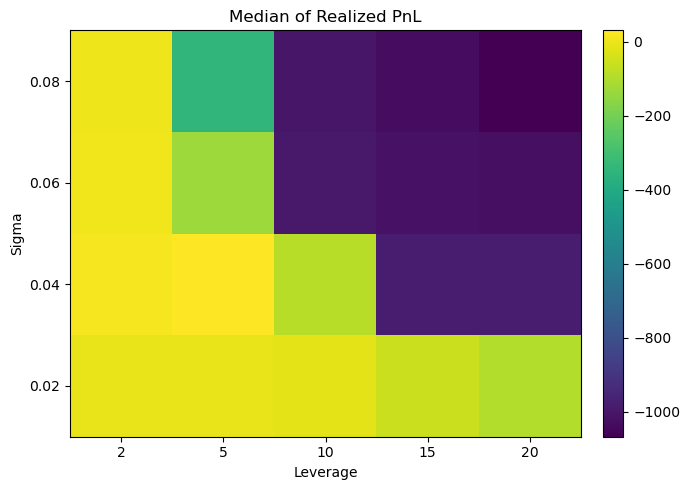

In [9]:

from typing import Callable

def heatmap_statistic_over_pnl(
    leverage_list: List[float],
    sigma_list: List[float],
    n_runs: int,
    base_price: PriceProcessParams,
    base_perp: PerpParams,
    stat_fn: Callable[[np.ndarray], float],
    stat_name: str = "Statistic"
) -> Tuple[np.ndarray, List[float], List[float]]:
    """Build a heatmap of a PnL-based statistic over (sigma, leverage)."""
    H = np.zeros((len(sigma_list), len(leverage_list)))
    for i, sig in enumerate(sigma_list):
        for j, L in enumerate(leverage_list):
            price_p = PriceProcessParams(**{**base_price.__dict__, "sigma": sig})
            perp_p  = PerpParams(**{**base_perp.__dict__, "leverage": L})
            out = simulate_batch(n_runs=n_runs, price_params=price_p, perp_params=perp_p)
            realized = out["df"]["realized_pnl"].values
            H[i, j] = stat_fn(realized)
    return H, sigma_list, leverage_list

# Build and plot Median PnL heatmap
H_median, yy_median, xx_median = heatmap_statistic_over_pnl(
    leverage_list=lev_grid,
    sigma_list=sigma_grid,
    n_runs=200,
    base_price=price_p,
    base_perp=perp_base,
    stat_fn=np.median,
    stat_name="Median Realized PnL"
)
plot_heatmap(H_median, yy_median, xx_median, title="Median of Realized PnL", xlabel="Leverage", ylabel="Sigma")



**Optional.** To switch to **Mean Realized PnL**, replace `np.median` with `np.mean` in the previous cell or run:
```python
H_mean, yy_mean, xx_mean = heatmap_statistic_over_pnl(
    leverage_list=lev_grid,
    sigma_list=sigma_grid,
    n_runs=200,
    base_price=price_p,
    base_perp=perp_base,
    stat_fn=np.mean,
    stat_name="Mean Realized PnL"
)
plot_heatmap(H_mean, yy_mean, xx_mean, title="Mean of Realized PnL", xlabel="Leverage", ylabel="Sigma")
```



<a id='presets'></a>

## 7) Protocol-Style Presets (Example)

Below is an example preset roughly aligned with a **high-leverage, hourly funding & borrow fee** environment.  
Adjust the parameters to match specific protocol rules (e.g., fee tiers, price impact model, maintenance formula).


In [10]:

def jupiter_like_preset() -> Tuple[PriceProcessParams, PerpParams]:
    price = PriceProcessParams(S0=145.51, mu=0.0, sigma=0.04, T=7, dt=1/24)
    perp = PerpParams(
        is_long=True,
        collateral=1000.0,
        leverage=10.0,
        trading_fee_rate=0.0006,      # open/close fee rate
        borrow_fee_rate=0.000027,     # per step units aligned with dt
        maintenance_margin_rate=0.002556,
        slippage_bps_open=20.0,       # optional price impact fee at entry
        apply_funding_fee=False,
    )
    return price, perp

# Quick sanity run with the preset
p0, x0 = jupiter_like_preset()
out = simulate_batch(n_runs=500, price_params=p0, perp_params=x0)
print(f"Preset — Average PnL: {out['avg_pnl']:.2f} | Liq Prob: {100*out['liq_prob']:.2f}%")


Preset — Average PnL: -53.25 | Liq Prob: 35.40%



<a id='tests'></a>

## 8) Reproducibility & Sanity Tests

These lightweight tests help catch regressions when editing the code.



<a id='appendixA'></a>

## 9) Appendix A — Fully Commented, Drop-in Implementations

Below are **drop-in replacements** of the core functions with detailed docstrings and inline comments.  
Execute Appendix A **before** running experiments if you want these versions to override the originals in the session.


In [ ]:

from dataclasses import dataclass
from typing import Dict, Any
import numpy as np
import pandas as pd

@dataclass
class PriceProcessParams:
    """Parameters for a discrete-time price process on a uniform grid.

    Attributes
    ----------
    S0 : float
        Initial spot price.
    mu : float
        Drift parameter (per day, if dt is in days).
    sigma : float
        Volatility parameter (per sqrt(day), if dt is in days).
    T : float
        Horizon in *days*.
    dt : float
        Time step in *days*. Example: 1/24 => hourly.
    process : str
        Process family to simulate. Currently only 'gbm' (Geometric Brownian Motion).
    """
    S0: float = 100.0
    mu: float = 0.0
    sigma: float = 0.5
    T: float = 7.0
    dt: float = 1/24
    process: str = "gbm"

def generate_price_path(p: PriceProcessParams) -> pd.DataFrame:
    """Simulate a single price path.
    
    GBM dynamics: S_{t+dt} = S_t * exp((mu - 0.5*sigma^2) dt + sigma sqrt(dt) z_t), z ~ N(0,1).
    Returns a DataFrame with columns:
      - 't' (time in days)
      - 'S' (simulated spot)
    """
    n_steps = int(np.round(p.T / p.dt))
    times = np.linspace(0, p.T, n_steps + 1)
    S = np.empty(n_steps + 1, dtype=float)
    S[0] = p.S0

    if p.process != "gbm":
        raise NotImplementedError(f"Process '{p.process}' not implemented")
    
    # Euler-Maruyama in log-space for GBM
    for t in range(n_steps):
        z = np.random.randn()
        drift = (p.mu - 0.5 * p.sigma**2) * p.dt
        diffusion = p.sigma * np.sqrt(p.dt) * z
        S[t+1] = S[t] * np.exp(drift + diffusion)

    return pd.DataFrame({"t": times, "S": S})

@dataclass
class PerpParams:
    """Canonical set of parameters for a cross-margined perpetual position.

    Key conventions
    ---------------
    - Collateral C and leverage L imply notional N = L*C at entry.
    - Quantity q = N / S0 (positive for long, negative for short).
    - Trading fees charged at open and close: rate * notional.
    - Borrow fees accrue over time on notional (scaled by dt).
    - Funding fee is modeled as a simple premium-to-EMA proxy (optional), sign depends on position side.
    - Liquidation condition: margin ratio MR_t = Equity_t / Notional_t <= maintenance_margin_rate.
    """
    is_long: bool = True
    collateral: float = 1000.0
    leverage: float = 10.0
    trading_fee_rate: float = 0.0006
    borrow_fee_rate: float = 0.000027
    maintenance_margin_rate: float = 0.005
    slippage_bps_open: float = 0.0
    slippage_bps_close: float = 0.0
    apply_funding_fee: bool = False
    funding_kappa: float = 0.0
    funding_ema_span: int = 24

def _ema(series: np.ndarray, span: int) -> np.ndarray:
    """Simple exponential moving average (EMA) with span parameter.
    
    This custom EMA avoids external dependencies and is deterministic.
    """
    if span <= 1:
        return series.astype(float).copy()
    alpha = 2.0 / (span + 1)
    y = np.empty_like(series, dtype=float)
    y[0] = series[0]
    for i in range(1, len(series)):
        y[i] = alpha * series[i] + (1 - alpha) * y[i-1]
    return y

def simulate_perp_single(price_df: pd.DataFrame, perp: PerpParams) -> Dict[str, Any]:
    """Simulate one perpetual position along a given price path.
    
    Parameters
    ----------
    price_df : pd.DataFrame
        Must contain columns 't' (days) and 'S' (spot).
    perp : PerpParams
        Position and fee parameters.
    
    Returns
    -------
    dict
        Keys include 'equity_path', 'upnl_path', 'funding_rate_path', 'price_path', 'time',
        'liquidated', 'liq_index', 'final_equity', 'final_upnl', 'fees_open', 
        'cum_borrow_fee', 'cum_funding_fee'.
    
    Notes
    -----
    - Equity_t = C + UPnL_t - (open_fee + cum_borrow_fee + cum_funding_fee).
    - When MR_t = Equity_t / Notional_t <= maintenance_margin_rate, liquidation is triggered.
      We deduct closing fees at that time and hold equity flat afterwards.
    - If no liquidation, we deduct closing fees at maturity (last step).
    """
    S = price_df["S"].values
    t = price_df["t"].values

    # Infer time increments from grid; assume uniform grid in days.
    dt = np.diff(t, prepend=t[0])
    dt[0] = dt[1] if len(dt) > 1 else dt[0]

    S0 = S[0]
    notional = perp.leverage * perp.collateral
    # Positive q for long, negative for short
    q = (notional / S0) * (1.0 if perp.is_long else -1.0)

    # Upfront fees at entry (open)
    open_trading_fee = perp.trading_fee_rate * abs(notional)
    open_slippage_fee = (perp.slippage_bps_open / 1e4) * abs(notional)
    fees_open = open_trading_fee + open_slippage_fee

    # Optional funding model based on premium to EMA of price
    if perp.apply_funding_fee and perp.funding_kappa != 0.0:
        ema_S = _ema(S, span=perp.funding_ema_span)
        premium = (S - ema_S) / np.maximum(ema_S, 1e-12)  # dimensionless premium
        funding_rate_path = perp.funding_kappa * premium
    else:
        funding_rate_path = np.zeros_like(S)

    equity = np.empty_like(S, dtype=float)
    upnl = np.empty_like(S, dtype=float)
    cum_funding_fee = 0.0
    cum_borrow_fee = 0.0

    liquidated = False
    liq_index = -1

    for i in range(len(S)):
        price_now = S[i]
        # Mark-to-market unrealized PnL versus entry
        upnl[i] = q * (price_now - S0)

        if i > 0:
            # Borrow fee accrues on notional (absolute), proportionally to dt[i]
            cum_borrow_fee += perp.borrow_fee_rate * abs(notional) * dt[i]
            # Funding fee: sign depends on side (long pays when funding_rate > 0)
            cum_funding_fee += (np.sign(q) * abs(notional) * funding_rate_path[i] * dt[i])

        total_fees = fees_open + cum_borrow_fee + cum_funding_fee
        equity[i] = perp.collateral + upnl[i] - total_fees

        # Margin ratio vs maintenance threshold
        notional_now = abs(q) * price_now
        mr = equity[i] / max(notional_now, 1e-12)

        # Trigger liquidation when maintenance breached
        if (not liquidated) and (mr <= perp.maintenance_margin_rate):
            liquidated = True
            liq_index = i
            # Deduct closing fees at the liquidation price
            close_fee = perp.trading_fee_rate * notional_now + (perp.slippage_bps_close/1e4) * notional_now
            equity[i] -= close_fee
            # Hold equity and PnL flat after liquidation
            equity[i:] = equity[i]
            upnl[i:] = upnl[i]
            break

    # If the position survives until maturity, deduct closing fees at the end
    if not liquidated:
        notional_end = abs(q) * S[-1]
        close_fee = perp.trading_fee_rate * notional_end + (perp.slippage_bps_close/1e4) * notional_end
        equity[-1] -= close_fee

    return {
        "equity_path": equity,
        "upnl_path": upnl,
        "funding_rate_path": funding_rate_path,
        "price_path": S,
        "time": t,
        "liquidated": liquidated,
        "liq_index": liq_index,
        "final_equity": float(equity[-1]),
        "final_upnl": float(upnl[-1]),
        "fees_open": float(fees_open),
        "cum_borrow_fee": float(cum_borrow_fee),
        "cum_funding_fee": float(cum_funding_fee),
    }
